In [ ]:
from google.colab import userdata
import os

os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')
os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

# https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview

100% 720M/723M [00:33<00:00, 26.1MB/s]
100% 723M/723M [00:33<00:00, 23.0MB/s]


In [ ]:
!unzip "jigsaw-unintended-bias-in-toxicity-classification.zip" -d "data"

Archive:  jigsaw-unintended-bias-in-toxicity-classification.zip
  inflating: data/all_data.csv       
  inflating: data/identity_individual_annotations.csv  
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/test_private_expanded.csv  
  inflating: data/test_public_expanded.csv  
  inflating: data/toxicity_individual_annotations.csv  
  inflating: data/train.csv          


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [ ]:
df = pd.read_csv('data/train.csv', parse_dates=['created_date'], date_format='ISO8601').rename(columns={'target': 'toxicity'})

In [ ]:
df.info(show_counts=True, memory_usage='deep')

# В столбцах, определяющих принадлежность к классу токсичности [toxicity, severe_toxicity, obscene, identity_attack, insult, threat, sexual_explicit], пропущенных значений нет
# Есть 3 пропущенных значения в столбце с текстом (comment_text)
# Только ~20% данных содержат аннотации к содержащимся в тексте сущностям (identities=[8(asian):32(white)])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Non-Null Count    Dtype              
---  ------                               --------------    -----              
 0   id                                   1804874 non-null  int64              
 1   toxicity                             1804874 non-null  float64            
 2   comment_text                         1804871 non-null  object             
 3   severe_toxicity                      1804874 non-null  float64            
 4   obscene                              1804874 non-null  float64            
 5   identity_attack                      1804874 non-null  float64            
 6   insult                               1804874 non-null  float64            
 7   threat                               1804874 non-null  float64            
 8   asian                                405130 non-null   float64            
 9   at

In [ ]:
toxicity_cols = [
    'toxicity',
    'severe_toxicity',
    'obscene',
    'identity_attack',
    'insult',
    'threat',
    'sexual_explicit']
identity_cols = [
    'asian',
    'atheist',
    'bisexual',
    'black',
    'buddhist',
    'christian',
    'female',
    'heterosexual',
    'hindu',
    'homosexual_gay_or_lesbian',
    'intellectual_or_learning_disability',
    'jewish',
    'latino',
    'male',
    'muslim',
    'other_disability',
    'other_gender',
    'other_race_or_ethnicity',
    'other_religion',
    'other_sexual_orientation',
    'physical_disability',
    'psychiatric_or_mental_illness',
    'transgender',
    'white']
comment_meta_cols = [
    'created_date',
    'publication_id',
    'parent_id',
    'article_id',
    'rating',
    'funny',
    'wow',
    'sad',
    'likes',
    'disagree']
annotation_meta_cols = [
    'toxicity_annotator_count',
    'identity_annotator_count']

In [ ]:
df['comment_text'].duplicated().sum()

# Кол-во дублирующих текстов (https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data#:~:text=other_disability-,Note,-that%20the%20data)
# Оставим из них те, у кого больше аннотаторов

24051

In [ ]:
df = df.dropna(subset='comment_text').sort_values(by='toxicity_annotator_count', ascending=False).drop_duplicates(subset='comment_text', keep='first').reset_index(drop=True)
df.shape

(1780822, 45)

In [ ]:
for col in toxicity_cols + identity_cols:
    df[col] = np.where(df[col].isna(), np.NaN, np.where(df[col]>=0.5, 1, 0))

df = df.astype({**{x:'int8' for x in toxicity_cols}, **{x:'float32' for x in identity_cols}})

# Преобразуем столбцы таргентных классов и столбцы сущностей из долей в бинарные переменные
# Сохраняем пропущенные значения (актуально только для сущностей)

In [ ]:
df[toxicity_cols].sum().rename('count').to_frame() \
    .assign(total_rows=df.shape[0],
            share_of_total=lambda df: df['count'] / df['total_rows']) \
    .drop(columns=['total_rows'])

# Кол-во наблюдений по каждому классу токсичности, доля от всех наблюдений

,count,share_of_total
toxicity,142534,0.080038
severe_toxicity,13,0.000007
obscene,9508,0.005339
identity_attack,13287,0.007461
insult,105079,0.059006
threat,4225,0.002372
sexual_explicit,4648,0.002610


In [ ]:
df['toxicity_any_kind'] = np.where(df[toxicity_cols].sum(axis=1) > 0, 1, 0)

df['toxicity_any_kind'].sum(), df['toxicity_any_kind'].sum() / df.shape[0]

# Кол-во наблюдений с хотя бы одним типом токсичности, доля от всех наблюдений

(146715, 0.08238611158217947)

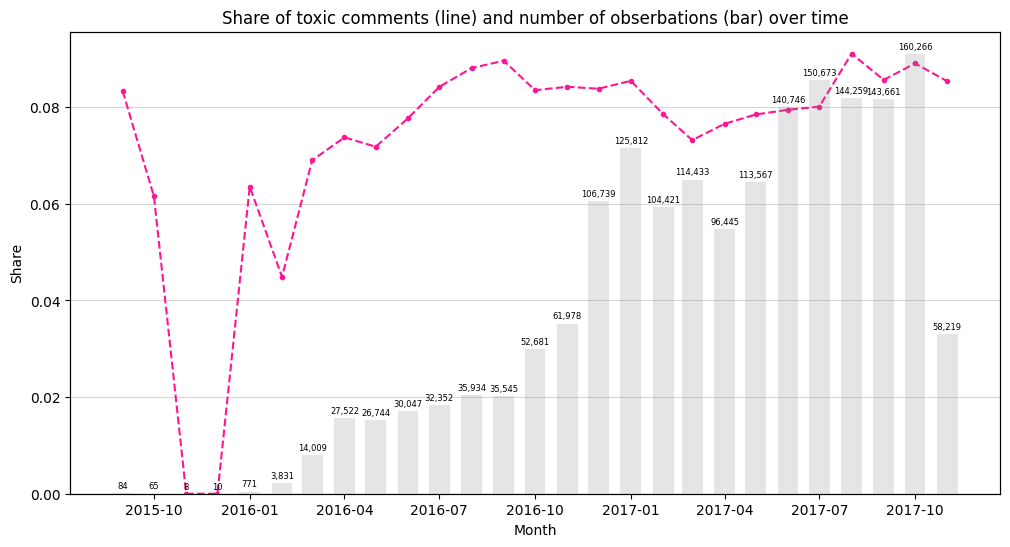

In [ ]:
# Общее число наблюдений и доля токсичных (любой тип токсичности) в датасете

fig, ax = plt.subplots(figsize=(12,6))

ax.plot('month', 'toxicity_any_kind', '.--',
        data=df.assign(month=lambda df: df['created_date'].dt.tz_localize(None).to_numpy().astype('datetime64[M]')).groupby('month', as_index=False)['toxicity_any_kind'].mean(),
        color='deeppink')

ax.set_title('Share of toxic comments (line) and number of observations (bar) over time')
ax.set_xlabel('Month')
ax.set_ylabel('Share')
ax.grid(axis='y', alpha=0.5)
ax.set_ylim(bottom=0)

ax1 = ax.twinx()

bar_container = ax1.bar('month', 'comment_text',
                        data=df.assign(month=lambda df: df['created_date'].dt.tz_localize(None).to_numpy().astype('datetime64[M]')).groupby('month', as_index=False)['comment_text'].count(),
                        width=datetime.timedelta(days=20), color='gray', alpha=0.2)

ax1.bar_label(bar_container, fmt='{:,.0f}', padding=2, fontsize=6)

ax1.yaxis.set_visible(False)

plt.show()

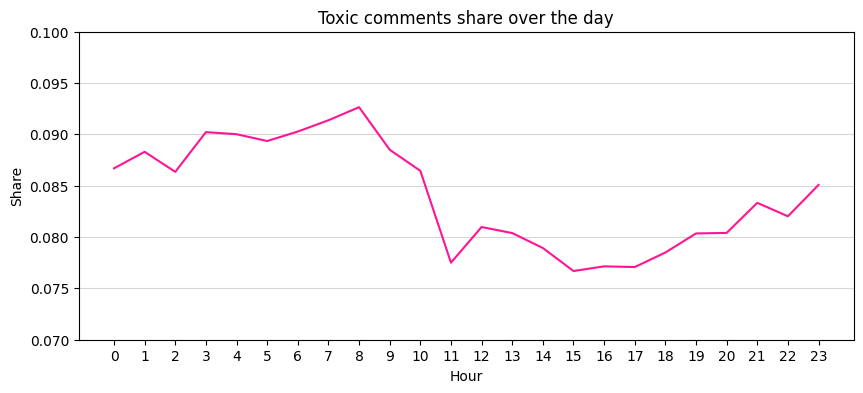

In [ ]:
# Доля токсичных комментариев (любой тип) в зависимости от времени суток

fig, ax = plt.subplots(figsize=(10,4))

ax.plot('hour', 'toxicity_any_kind', data=df.assign(hour=lambda df: df['created_date'].dt.tz_localize(None).dt.hour).groupby('hour', as_index=False)['toxicity_any_kind'].mean(), color='deeppink')

ax.set_title('Toxic comments share over the day')
ax.set_xlabel('Hour')
ax.set_ylabel('Share')
ax.grid(axis='y', alpha=0.5)
ax.set_ylim(bottom=round(ax.get_ybound()[0]*0.9, 2), top=round(ax.get_ybound()[1]*1.1, 2))
ax.set_xticks(np.arange(0, 24, 1))

plt.show()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import unicodedata
import string

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [ ]:
df[['text_length', 'num_words', 'num_sent', 'num_punct']] = df[['comment_text']] \
    .progress_apply(lambda row: (len(row['comment_text']),
                                 len(nltk.tokenize.word_tokenize(row['comment_text'])),
                                 len(nltk.tokenize.sent_tokenize(row['comment_text'])),
                                 sum([ch in string.punctuation for ch in row['comment_text']])),
                    axis=1, result_type='expand')

  0%|          | 0/1780822 [00:00<?, ?it/s]

In [ ]:
df.groupby(by='toxicity_any_kind', as_index=False)[['text_length', 'num_words', 'num_sent', 'num_punct']].mean()

# Средняя длина текста (кол-во символов), кол-во слов, кол-во предложений и кол-во знаков пунктуации в токсичных и нетоксичных комментариях
# Использовались стандартные токенизаторы nltk

,toxicity_any_kind,text_length,num_words,num_sent,num_punct
0,0,301.223190,60.213137,3.555870,9.947190
1,1,281.071629,57.129257,3.638653,9.560877


In [ ]:
# Собираем токенизатор со следующими функциями:
# 1. Нормализация документа через unicodedata.normalize('NFKD', x)
# 2. Токенизация через TweetTokenizer из nltk
# 3. Удаление стоп-слов (stopwords('english') из nltk) и знаков пунктуации (string.punctuation) (только токены единичной длины)
# 4. Определение части речи (pos_tag из nltk)
# 5. Лемматизация через WordNetLemmatizer из nltk с указанием части речи

class PreprocessLemmaTokenizer:
    def __init__(self):
        self.wnl = nltk.stem.WordNetLemmatizer()
        self.tknzr = nltk.tokenize.TweetTokenizer()
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.punctuation = set(string.punctuation)

    @staticmethod
    def _normalize(doc):
        return unicodedata.normalize('NFKD', doc).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    @staticmethod
    def _get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return nltk.corpus.wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return nltk.corpus.wordnet.VERB
        elif treebank_tag.startswith('N'):
            return nltk.corpus.wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return nltk.corpus.wordnet.ADV
        else:
            return nltk.corpus.wordnet.NOUN

    def __call__(self, doc):
        return [self.wnl.lemmatize(token.lower(), pos=self._get_wordnet_pos(postag)) for token, postag in nltk.pos_tag(self.tknzr.tokenize(self._normalize(doc))) if token.lower() not in self.stopwords.union(self.punctuation)]

In [ ]:
# Пример работы токенизатора

df[['comment_text']][:5] \
    .assign(text_tokenized=lambda df: df['comment_text'].apply(PreprocessLemmaTokenizer())) \
    .style

,comment_text,text_tokenized
0,You can stick your dick up anyone's butt. Why have any laws at all?,"['stick', 'dick', ""anyone's"", 'butt', 'law']"
1,I bet your fat bitter little nerd ass was waiting all day to find a way to tie THE PRESIDENT to this. Get laid you ugly mother fu...,"['bet', 'fat', 'bitter', 'little', 'nerd', 'as', 'wait', 'day', 'find', 'way', 'tie', 'president', 'get', 'lay', 'ugly', 'mother', 'fu', '...']"
2,I hope you die today. The world will be much better off without filth like you in it.,"['hope', 'die', 'today', 'world', 'much', 'good', 'without', 'filth', 'like']"
3,Let them die .. Maybe we should build concentration camps with gas chambers... hurry that death on a bit?.,"['let', 'die', '..', 'maybe', 'build', 'concentration', 'camp', 'gas', 'chamber', '...', 'hurry', 'death', 'bit']"
4,If we shoot them it will be a permanent solution. These creatures are a waste of space.,"['shoot', 'permanent', 'solution', 'creature', 'waste', 'space']"


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Подсчет частоты слов (токенов) с использованием CountVectorizer и кастомного токенизатора

vectorizer = CountVectorizer(min_df=2, tokenizer=PreprocessLemmaTokenizer(), strip_accents=None, lowercase=False, preprocessor=None, stop_words=None, token_pattern=None)
X = vectorizer.fit_transform(df[df['toxicity_any_kind']==1]['comment_text'])

token_frequency_dict = dict(zip(vectorizer.get_feature_names_out(), np.asarray(X.sum(axis=0))[0]))

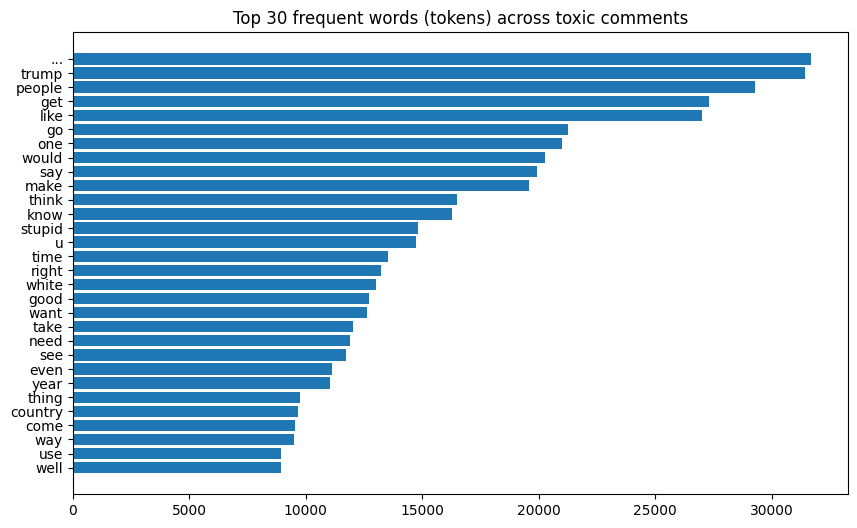

In [ ]:
# Топ наиболее частых токенов среди токсичных комментариев (любой тип)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh('word', 'count',
        data=pd.DataFrame.from_records(sorted(token_frequency_dict.items(), key=lambda x: x[1], reverse=True)[:30], columns=['word', 'count']))

ax.set_title('Top 30 frequent words (tokens) across toxic comments')
ax.invert_yaxis()

plt.show()

In [ ]:
from wordcloud import WordCloud

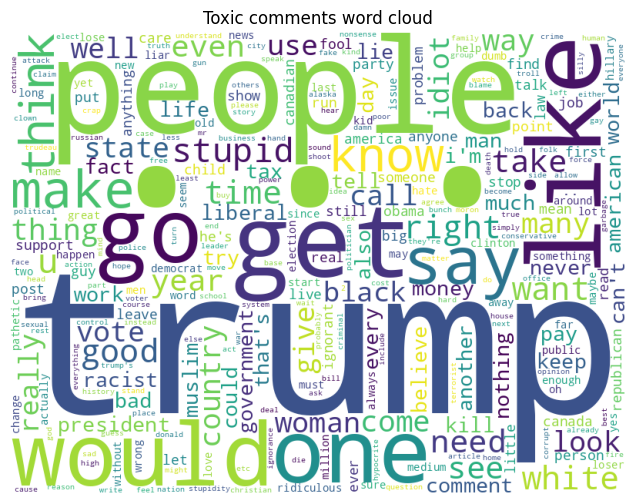

In [ ]:
# Облако слов для токсичных комментариев (любой тип)

wc = WordCloud(width=800, height=600, max_words=300, background_color='white').generate_from_frequencies(token_frequency_dict)

fig, ax = plt.subplots(figsize=(8,6))
ax.axis('off')
ax.imshow(wc)
ax.set_title('Toxic comments word cloud')

plt.show()

In [ ]:
# Подсчет частоты триграм с использованием CountVectorizer и кастомного токенизатора

vectorizer_3 = CountVectorizer(ngram_range=(3, 3), tokenizer=PreprocessLemmaTokenizer(), strip_accents=None, lowercase=False, preprocessor=None, stop_words=None, token_pattern=None)
X_3 = vectorizer_3.fit_transform(df[df['toxicity_any_kind']==1]['comment_text'])

token_frequency_dict_3 = dict(zip(vectorizer_3.get_feature_names_out(), np.asarray(X_3.sum(axis=0))[0]))

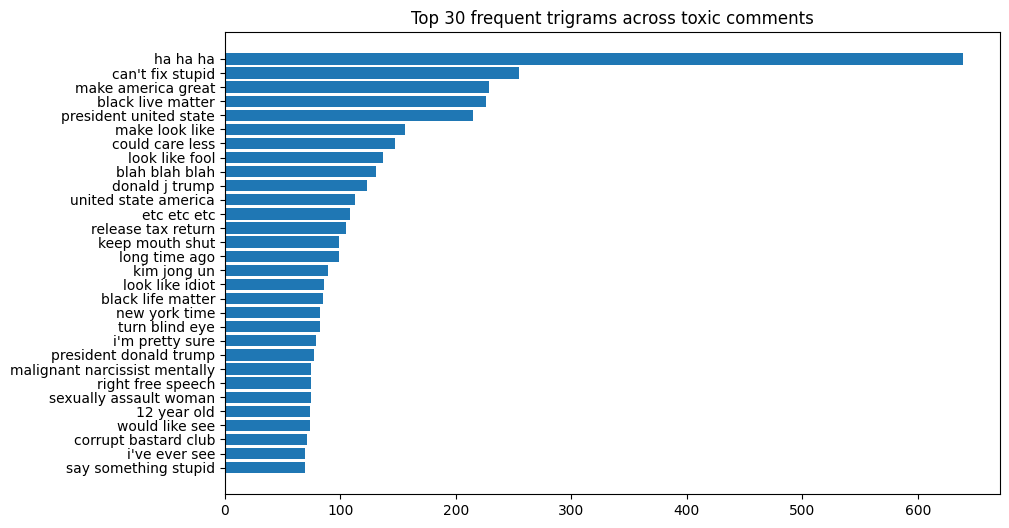

In [ ]:
# Топ наиболее частых триграм среди токсичных комментариев (любой тип)

fig, ax = plt.subplots(figsize=(10,6))

ax.barh('word', 'count',
        data=pd.DataFrame.from_records(sorted(token_frequency_dict_3.items(), key=lambda x: x[1], reverse=True)[:30], columns=['word', 'count']))

ax.set_title('Top 30 frequent trigrams across toxic comments')
ax.invert_yaxis()

plt.show()

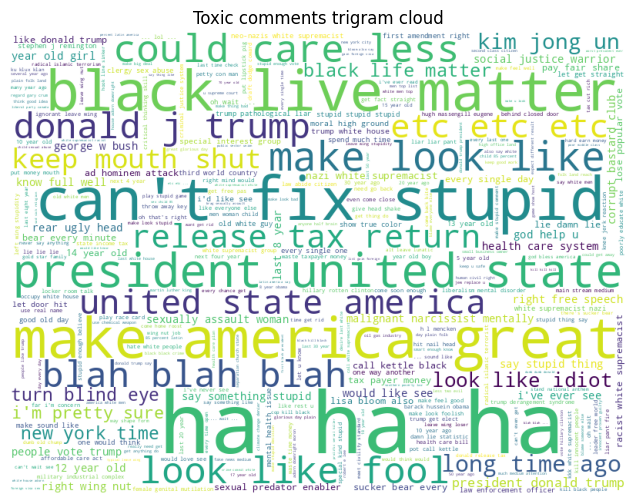

In [ ]:
# Облако слов для триграм среди токсичных комментариев (любой тип)

wc = WordCloud(width=800, height=600, max_words=300, background_color='white').generate_from_frequencies(token_frequency_dict_3)

fig, ax = plt.subplots(figsize=(8,6))
ax.axis('off')
ax.imshow(wc)
ax.set_title('Toxic comments trigram cloud')

plt.show()